## 细胞核DAPI图像数据预处理
样本信息：https://www.10xgenomics.com/datasets/human-kidney-preview-data-xenium-human-multi-tissue-and-cancer-panel-1-standard
选择乳头状肾细胞癌组织进行验证

In [6]:
import h5py
import numpy as np
from scipy import sparse
import pandas as pd
from scipy.sparse import csc_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import tifffile
import os
from PIL import Image
from tqdm import tqdm
from skimage.draw import polygon as polyfill 
from skimage.draw import polygon2mask

In [7]:
h5_path = "./data/hKidney_cancer_section_outs/cell_feature_matrix.h5"
nucleus_location_path = "./data/hKidney_cancer_section_outs/nucleus_boundaries.parquet"
tifffile_path = "./data/hKidney_cancer_section_outs/morphology_focus.ome.tif"
gene_panel_path = "./data/hKidney_cancer_section_outs/gene_panel.json"

In [8]:
with h5py.File(h5_path, "r") as f:
    def print_structure(name, obj):
        print(name)
    f.visititems(print_structure)

matrix
matrix/barcodes
matrix/data
matrix/features
matrix/features/_all_tag_keys
matrix/features/feature_type
matrix/features/genome
matrix/features/id
matrix/features/name
matrix/indices
matrix/indptr
matrix/shape


In [9]:
with h5py.File(h5_path, "r") as f:
    ## load sparse matrix
    data = f["matrix/data"][:]
    indices = f["matrix/indices"][:]
    indptr = f["matrix/indptr"][:]
    shape = tuple(f["matrix/shape"][:])  # (n_features x n_cells)

    ## load feature info
    feature_names = [x.decode() for x in f["matrix/features/name"][:]]
    feature_ids = [x.decode() for x in f["matrix/features/id"][:]]
    feature_types = [x.decode() for x in f["matrix/features/feature_type"][:]]
    barcodes = [x.decode() for x in f["matrix/barcodes"][:]]

print(shape)

(np.int32(541), np.int32(56510))


In [10]:
print(feature_names)

['ABCC11', 'ACE2', 'ACKR1', 'ACTA2', 'ACTG2', 'ADAM28', 'ADAMTS1', 'ADGRE1', 'ADGRL4', 'ADH1C', 'ADH4', 'ADIPOQ', 'AGER', 'AGR3', 'AHSP', 'AIF1', 'ALAS2', 'ALDH1A3', 'AMY2A', 'ANGPT2', 'ANPEP', 'APCDD1', 'APOA5', 'APOBEC3A', 'APOLD1', 'AQP2', 'AQP3', 'AQP8', 'AQP9', 'AR', 'ARFGEF3', 'ASCL1', 'ASCL3', 'ASPN', 'BAMBI', 'BANK1', 'BASP1', 'BBOX1', 'BCL2L11', 'BMX', 'BTNL9', 'C15orf48', 'C1orf162', 'C1orf194', 'C20orf85', 'C5orf46', 'C6orf118', 'C7', 'CA4', 'CAPN8', 'CAV1', 'CAVIN1', 'CAVIN2', 'CCDC39', 'CCDC78', 'CCL19', 'CCL27', 'CCL5', 'CCNB2', 'CCR2', 'CCR7', 'CD14', 'CD163', 'CD19', 'CD1A', 'CD1C', 'CD1E', 'CD2', 'CD247', 'CD27', 'CD274', 'CD28', 'CD300E', 'CD34', 'CD3D', 'CD3E', 'CD4', 'CD5L', 'CD68', 'CD69', 'CD70', 'CD79A', 'CD83', 'CD86', 'CD8A', 'CD93', 'CDH16', 'CDK1', 'CENPF', 'CFAP53', 'CFB', 'CFHR1', 'CFHR3', 'CFTR', 'CHGA', 'CLCA1', 'CLCA2', 'CLEC10A', 'CLEC14A', 'CLEC4E', 'CLECL1', 'CLIC6', 'CNN1', 'COCH', 'COL17A1', 'COL5A2', 'CPA3', 'CRHBP', 'CRISPLD2', 'CSF2RA', 'CSF3', '

In [11]:
## load expression matrix
expr_matrix = csc_matrix((data, indices, indptr), shape=shape)
print("Shape of matrix (features x cells):", expr_matrix.shape)

Shape of matrix (features x cells): (541, 56510)


### 处理细胞核位置信息

In [12]:
## 读取细胞核位置文件
nucleus_table = pq.read_table(nucleus_location_path)
nuclues_df = nucleus_table.to_pandas()
print(nuclues_df.head())

      cell_id    vertex_x    vertex_y
0  aaaanpll-1  845.962524  586.924988
1  aaaanpll-1  844.475037  587.775024
2  aaaanpll-1  844.262512  589.475037
3  aaaanpll-1  844.687500  590.962524
4  aaaanpll-1  845.750000  592.025024


In [13]:
## 给相同的细胞加上label_id
nuclues_df["label_id"] = pd.factorize(nuclues_df["cell_id"])[0]
print(nuclues_df.head())

      cell_id    vertex_x    vertex_y  label_id
0  aaaanpll-1  845.962524  586.924988         0
1  aaaanpll-1  844.475037  587.775024         0
2  aaaanpll-1  844.262512  589.475037         0
3  aaaanpll-1  844.687500  590.962524         0
4  aaaanpll-1  845.750000  592.025024         0


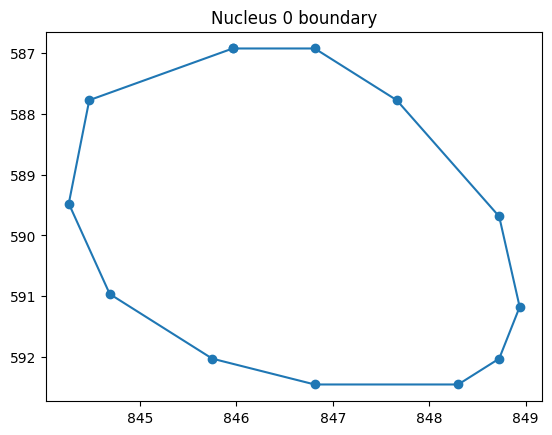

In [14]:
## 先简单可视化细胞"aaaanpll-1"的细胞核轮廓
df_sub = nuclues_df[nuclues_df["label_id"] == 0]

plt.plot(df_sub["vertex_x"], df_sub["vertex_y"], marker='o')
plt.gca().invert_yaxis()  # 图像y轴朝下
plt.title(f"Nucleus {0} boundary")
plt.show()

In [15]:
# 计算每个 label_id（即每个细胞核）的几何中心
nucleus_centroids = (
    nuclues_df.groupby(["label_id", "cell_id"])[["vertex_x", "vertex_y"]]
    .mean()
    .reset_index()
    .rename(columns={"vertex_x": "x_centroid", "vertex_y": "y_centroid"})
)

print(nucleus_centroids.head())

   label_id     cell_id  x_centroid  y_centroid
0         0  aaaanpll-1  846.698120  589.736572
1         1  aaabddcj-1  821.214478  683.547119
2         2  aaadbdpm-1  849.705811  773.598083
3         3  aaaebncm-1  677.253845  869.255798
4         4  aaaegoge-1  639.445190   21.724039


## 查看具体的gene panel，尝试对细胞进行dividing打分

In [16]:
X = csc_matrix((data, indices, indptr), shape=shape)
print(X.shape)

(541, 56510)


In [17]:
## 提取panel中的细胞增殖marker
proli_genes = ["CCNB2", "CDK1", "PCNA"]
gene_to_index = {g: i for i, g in enumerate(feature_names)}

# 过滤存在的基因
proli_genes_present = [g for g in proli_genes if g in gene_to_index]
proli_indices = [gene_to_index[g] for g in proli_genes_present]

# 提取表达谱
proli_expr = X[proli_indices, :].toarray().T  # 转置成 (n_cells, n_genes)

proli_expr_df = pd.DataFrame(proli_expr, columns=proli_genes_present, index=barcodes)
print(proli_expr_df.head())

            CCNB2  CDK1  PCNA
aaaanpll-1      0     0     0
aaabddcj-1      0     0     0
aaadbdpm-1      0     1     0
aaaebncm-1      0     0     0
aaaegoge-1      0     0     0


In [18]:
## 选择两个G2/M的marker来打dividing label
threshold_cdk1 = proli_expr_df["CDK1"].quantile(0.75)  
threshold_ccnb2 = proli_expr_df["CCNB2"].quantile(0.75)

print(threshold_cdk1, threshold_ccnb2)

dividing_label = ((proli_expr_df["CDK1"] > threshold_cdk1) &
                  (proli_expr_df["CCNB2"] > threshold_ccnb2)).astype(int)

print(len(dividing_label[dividing_label == 1]))
proli_expr_df["dividing_label"] = dividing_label

0.0 0.0
756


count    756.000000
mean       1.119048
std        2.562926
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       31.000000
Name: PCNA, dtype: float64


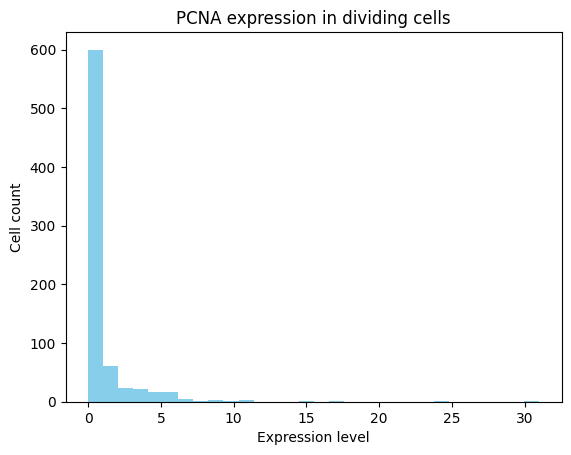

In [19]:
subset_df = proli_expr_df[proli_expr_df["dividing_label"] == 1]
pcna_values = subset_df["PCNA"]
print(pcna_values.describe())

plt.hist(pcna_values, bins=30, color='skyblue')
plt.title("PCNA expression in dividing cells")
plt.xlabel("Expression level")
plt.ylabel("Cell count")
plt.show()

In [20]:
print(np.percentile(pcna_values, 95))

5.0


In [21]:
## 根据PCNA表达值来过滤掉假阳性dividing细胞
dividing_mask = dividing_label == 1

# 设置 PCNA 的 upper bound，过滤掉 PCNA 过高的假阳性
pcna_threshold = np.percentile(pcna_values, 60)  
final_dividing_mask = dividing_mask & (proli_expr_df["PCNA"] <= pcna_threshold)

# 更新标签
final_dividing_label = final_dividing_mask.astype(int)

proli_expr_df["dividing_label"] = final_dividing_label

print(pcna_threshold)
print(len(final_dividing_label[final_dividing_label == 1]))

1.0
600


In [22]:
## 追加一列dividing label
merged_df = nucleus_centroids
merged_df["dividing_label"] = merged_df["cell_id"].map(final_dividing_label)

print(merged_df.head)

<bound method NDFrame.head of        label_id     cell_id   x_centroid   y_centroid  dividing_label
0             0  aaaanpll-1   846.698120   589.736572               0
1             1  aaabddcj-1   821.214478   683.547119               0
2             2  aaadbdpm-1   849.705811   773.598083               0
3             3  aaaebncm-1   677.253845   869.255798               0
4             4  aaaegoge-1   639.445190    21.724039               0
...         ...         ...          ...          ...             ...
56505     56505  oifnoema-1  5958.892578  1786.225952               0
56506     56506  oifobjjn-1  5958.108398  1750.182739               0
56507     56507  oifomgpl-1  5958.156738  1776.205811               0
56508     56508  oifoolfj-1  5960.903320  1748.629761               0
56509     56509  oifpecnn-1  5957.012695  1794.072144               0

[56510 rows x 5 columns]>


### 导入细胞核染色图像

In [23]:
## 导入图像
with tifffile.TiffFile(tifffile_path) as tif:
    print(f"图像共有 {len(tif.pages)} 层") ## 一层
    dapi_img = tif.pages[0].asarray()  
    print("读取图像形状：", dapi_img.shape)

图像共有 1 层
读取图像形状： (10346, 36943)


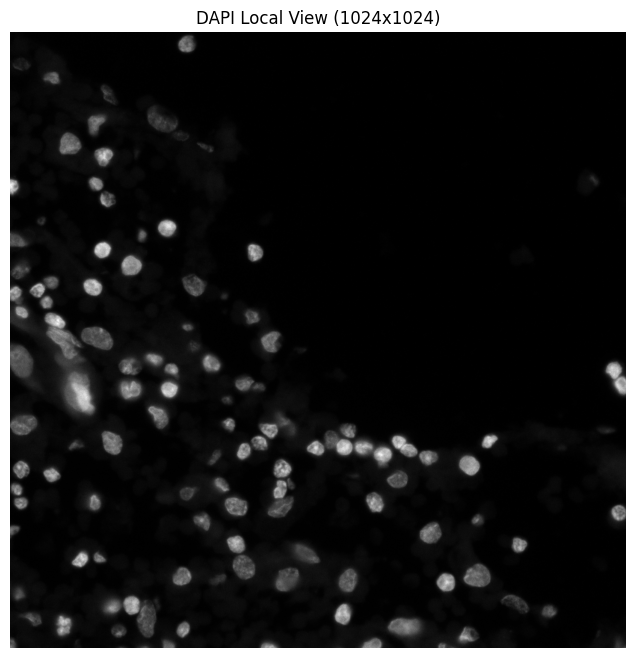

In [24]:
import matplotlib.pyplot as plt

# 中心区域裁剪
H, W = dapi_img.shape
center_y, center_x = H // 2, W // 2
crop_size = 1024  # 可改为 512, 2048 等

crop = dapi_img[
    center_y - crop_size // 2 : center_y + crop_size // 2,
    center_x - crop_size // 2 : center_x + crop_size // 2
]

plt.figure(figsize=(8, 8))
plt.imshow(crop, cmap='gray')
plt.title(f"DAPI Local View ({crop_size}x{crop_size})")
plt.axis('off')
plt.show()

In [25]:
## scale_factor设置为0.2125(参考：https://kb.10xgenomics.com/hc/en-us/articles/11636252598925-What-are-the-Xenium-image-scale-factors?utm_source=chatgpt.com)
## 裁剪patch+QC
def extract_dapi_patches(
    dapi_img, 
    merged_df,              # 包含 barcode, x_centroid(µm), y_centroid(µm), dividing_label
    nucleus_df,             # 包含 cell_id(barcode), vertex_x(µm), vertex_y(µm), label_id
    patch_um=20,            # patch大小（单位µm）
    scale=0.2125,           # µm -> px 的缩放系数
    normalize=True,         # 是否归一化图像
    qc_min_mean=0.05,       # 荧光强度下限
    qc_max_mean=0.95,        # 荧光强度上限
    max_samples = 20
):
    patch_size = int(round(patch_um / scale))
    if patch_size % 2 == 0:
        patch_size += 1
    half_size = patch_size // 2

    df = merged_df.copy()
    df["x_px"] = (df["x_centroid"] / scale).round().astype(int)
    df["y_px"] = (df["y_centroid"] / scale).round().astype(int)

    # ===============================
    # 构建 barcode → list of (xs, ys) 多边形列表（全局像素坐标）
    # ===============================
    poly_lookup = {}
    nuc = nucleus_df.copy()

    # 排序顶点顺序列（若存在）
    vorder_col = next((c for c in nuc.columns if "order" in c.lower()), None)

    group_cols = ["cell_id"]
    if "label_id" in nuc.columns:
        group_cols.append("label_id")

    for keys, g in nuc.groupby(group_cols):
        if vorder_col:
            g = g.sort_values(vorder_col)
        if len(g) < 3:
            continue
        xs = (g["vertex_x"].to_numpy(dtype=np.float64) / scale)
        ys = (g["vertex_y"].to_numpy(dtype=np.float64) / scale)
        cell_id = keys[0] if isinstance(keys, tuple) else keys
        poly_lookup.setdefault(cell_id, []).append((xs, ys))

    # ===============================
    # 主循环：裁剪、掩膜、归一化、质控
    # ===============================
    patches, labels, barcodes = [], [], []
    H, W = dapi_img.shape[:2]
    count = 0   

    for _, row in tqdm(df.iterrows(), total=len(df)):
        bc = row["cell_id"]
        x, y = int(row["x_px"]), int(row["y_px"])
        label = int(row["dividing_label"])

        # 越界直接跳过
        if x - half_size < 0 or x + half_size >= W or y - half_size < 0 or y + half_size >= H:
            continue

        if bc not in poly_lookup:
            continue

        # 裁剪patch
        patch = dapi_img[y - half_size : y + half_size + 1, x - half_size : x + half_size + 1].astype(np.float32)

        # 创建mask（bool数组）
        mask = np.zeros((patch_size, patch_size), dtype=bool)
        for xs_glob, ys_glob in poly_lookup[bc]:
            xs_local = xs_glob - (x - half_size)
            ys_local = ys_glob - (y - half_size)
            rr, cc = polyfill(ys_local, xs_local, shape=mask.shape)
            mask[rr, cc] = True

        # 核外区域设置为 0
        patch[~mask] = 0.0

        # 若图像全为 0，则跳过
        if patch.max() == patch.min():
            continue

        # 归一化（仅限非零区域）
        if normalize:
            valid_pixels = patch[mask]
            pmin, pmax = valid_pixels.min(), valid_pixels.max()
            if pmax > pmin:
                patch[mask] = (valid_pixels - pmin) / (pmax - pmin + 1e-5)
            else:
                continue

        # 强度 QC
        mean_intensity = patch[mask > 0].mean()
        if not (qc_min_mean <= mean_intensity <= qc_max_mean):
            continue

        # 收集数据
        patches.append(patch)
        labels.append(label)
        barcodes.append(bc)
        count += 1

        if max_samples is not None and count >= max_samples:
            print(f"提前终止，仅提取前 {max_samples} 个样本用于测试")
            break

    # 样本不足报错
    if len(patches) == 0:
        raise RuntimeError("没有通过边界/掩膜/QC 的patch，请检查输入与阈值设置。")

    patches = np.stack(patches).astype(np.float32)  # shape: (N, H, W)
    labels = np.asarray(labels, dtype=np.int8)
    barcodes = np.asarray(barcodes, dtype=object)

    print(f"成功提取 {len(patches):,} 个 patch，尺寸：{patches.shape[1:]}")

    return patches, labels, barcodes

In [26]:
vali_patches,vali_labels, vali_barcodes = extract_dapi_patches(
    dapi_img=dapi_img,                   
    merged_df=merged_df,       
    nucleus_df=nuclues_df,               
    patch_um=15,
    scale=0.2125,
    normalize=True,
    qc_min_mean=0.3,
    qc_max_mean=0.8,
    max_samples=None
)

100%|██████████| 56510/56510 [00:09<00:00, 5868.07it/s]


成功提取 55,848 个 patch，尺寸：(71, 71)


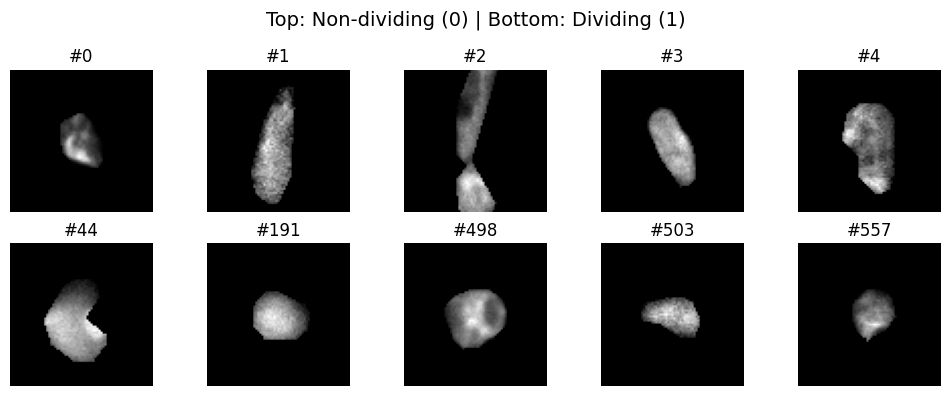

In [27]:
def plot_patch_examples(patches, labels, n_per_class=5):
    fig, axs = plt.subplots(2, n_per_class, figsize=(n_per_class * 2, 4))
    fig.suptitle("Top: Non-dividing (0) | Bottom: Dividing (1)", fontsize=14)

    # 每类取前n个
    idx_0 = np.where(labels == 0)[0][:n_per_class]
    idx_1 = np.where(labels == 1)[0][:n_per_class]

    for i in range(n_per_class):
        # 非分裂细胞
        axs[0, i].imshow(patches[idx_0[i]], cmap='gray')
        axs[0, i].axis("off")
        axs[0, i].set_title(f"#{idx_0[i]}")

        # 分裂细胞
        axs[1, i].imshow(patches[idx_1[i]], cmap='gray')
        axs[1, i].axis("off")
        axs[1, i].set_title(f"#{idx_1[i]}")

    plt.tight_layout()
    plt.show()

plot_patch_examples(vali_patches, vali_labels, n_per_class=5)

In [28]:
## 保存图像为h5文件
def save_patches_to_hdf5(images, labels, barcodes, out_dir="./result"):
    num_samples = len(vali_patches)
    out_path = f"{out_dir}/dapi_patches_20um_vali_{num_samples}.h5"

    with h5py.File(out_path, "w") as f:
        f.create_dataset("images", data=images, compression="gzip")
        f.create_dataset("labels", data=labels)
        f.create_dataset("barcodes", data=barcodes, dtype=h5py.string_dtype(encoding='utf-8'))
    
    print(f"已保存 {len(images)} 个 patch 到 HDF5 文件：{out_path}")
    print(f"HDF5 中图像 shape: {images.shape}, 标签 shape: {labels.shape}")

save_patches_to_hdf5(vali_patches, vali_labels, vali_barcodes, out_dir="./result")

已保存 55848 个 patch 到 HDF5 文件：./result/dapi_patches_20um_vali_55848.h5
HDF5 中图像 shape: (55848, 71, 71), 标签 shape: (55848,)
